<a href="https://colab.research.google.com/github/YannisBr/Empreinte_Carbone/blob/main/ML_officiel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FAIRE CA :

Ensemble d'entraînement : utilisé pour entraîner le modèle.
Ensemble de validation : utilisé pour évaluer le modèle pendant l'entraînement et ajuster les hyperparamètres.
Ensemble de test : utilisé pour tester la performance finale du modèle après l'entraînement.

Reflechir sur validation croisée

# **Prétraitement des données**

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# Installer la bibliothèque surprise si ce n'est pas encore fait
!pip install surprise

# Importer les modules nécessaires
from surprise import Reader, Dataset
from surprise import KNNBasic
from surprise.model_selection import cross_validate



from google.colab import files
uploaded = files.upload()

# Chargement des données
ratings_train = np.load('ratings_train.npy')
ratings_test = np.load('ratings_test.npy')
name_genres = np.load('namesngenre.npy', allow_pickle=True)
list_index_wanted = np.load('list_index_wanted.npy', allow_pickle=True)

# Visualisation des données
# 1. Visualisation de ratings_train
print("Dimensions de ratings_train:", ratings_train.shape)
print("Aperçu de ratings_train:\n", ratings_train)

# 2. Visualisation de ratings_test
print("\nDimensions de ratings_test:", ratings_test.shape)
print("Aperçu de ratings_test:\n", ratings_test)

# 3. Visualisation de name_genres
print("\nAperçu de name_genres:")
print(name_genres[:10])  # Affiche les 10 premières lignes pour voir la structure

# 4. Visualisation de list_index_wanted
print("\nAperçu de list_index_wanted:")
print(list_index_wanted[:10])  # Affiche les 10 premières lignes pour voir la structure


# Vérification des dimensions de la matrice
nb_users = ratings_train.shape[0]
nb_movies = ratings_train.shape[1]

print("Il y a %d utilisateurs uniques et %d films uniques; "
      "la matrice est donc de taille %d par %d." % (nb_users, nb_movies, nb_users, nb_movies))

ratings_train_filled = np.nan_to_num(ratings_train, nan=0)

# Transposition de la matrice pour obtenir utilisateurs en lignes et produits en colonnes
data_matrix = ratings_train_filled

print("Aperçu de data_matrix (sans NaN):\n", data_matrix)

print("Dimensions :", data_matrix.shape)



Dimensions de ratings_train: (610, 4980)
Aperçu de ratings_train:
 [[ 4. nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan  2. nan ... nan nan nan]
 [ 3. nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]

Dimensions de ratings_test: (610, 4980)
Aperçu de ratings_test:
 [[nan nan  4. ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan  2. ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [ 5. nan nan ... nan nan nan]]

Aperçu de name_genres:
[['Toy Story (1995)' 'Adventure|Animation|Children|Comedy|Fantasy']
 ['Jumanji (1995)' 'Adventure|Children|Fantasy']
 ['Grumpier Old Men (1995)' 'Comedy|Romance']
 ['Waiting to Exhale (1995)' 'Comedy|Drama|Romance']
 ['Father of the Bride Part II (1995)' 'Comedy']
 ['Heat (1995)' 'Action|Crime|Thriller']
 ['Sabrina (1995)' 'Comedy|Romance']
 ['Tom and Huck (1995)' 'Adventure|Children']
 ['Sudden Death (1995)' 'Action']
 ['GoldenEye (1995)' 'Action|Adventu

# **Implémention des modèles**

# KNN

In [127]:

# 1. Convertir la matrice de données en un DataFrame Surprise
# Supposons que data_matrix soit une matrice où les lignes sont les utilisateurs et les colonnes les films

# Créer un DataFrame avec des colonnes userID, movieID, rating
# On suppose que data_matrix contient les évaluations avec les indices utilisateur et film
user_ids, movie_ids = np.where(data_matrix != 0)  # Trouver les indices des évaluations non nulles
ratings = data_matrix[user_ids, movie_ids]  # Obtenir les évaluations

# Créer un DataFrame pandas pour ces données
ratings_df = pd.DataFrame({
    'userID': user_ids,
    'movieID': movie_ids,
    'rating': ratings
})

# 2. Créer un Reader et charger le dataset
reader = Reader(rating_scale=(1, 5))  # Si vos notes vont de 1 à 5
data = Dataset.load_from_df(ratings_df[['userID', 'movieID', 'rating']], reader)

# 3. Appliquer l'algorithme KNN avec distance cosinus
knn = KNNBasic(sim_options={'name': 'cosine', 'user_based': True})

# 4. Évaluer la performance du modèle via une validation croisée (3-fold cross-validation)
results = cross_validate(knn, data, measures=['RMSE', 'MAE'], cv=3)

# Afficher les résultats
print(f"RMSE moyen : {np.mean(results['test_rmse'])}")
print(f"MAE moyen : {np.mean(results['test_mae'])}")


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE moyen : 1.0293522975613894
MAE moyen : 0.7944364073156484


In [128]:
# 4. Obtenir les prédictions pour les indices dans list_index_wanted
predictions_wanted = []

for idx in list_index_wanted:
    user_idx, movie_idx = idx  # Extraire les indices utilisateur et film
    # Prédire la note pour l'utilisateur et le film spécifiés
    pred = knn.predict(user_idx, movie_idx).est  # `.est` donne la prédiction estimée

    # Arrondir la prédiction pour obtenir un entier
    pred_rounded = round(pred)  # Arrondi de la prédiction pour obtenir un entier

    predictions_wanted.append([user_idx, movie_idx, pred_rounded])  # Ajouter dans la liste sous forme de tuple

# 5. Convertir la liste en DataFrame pour avoir un tableau clair
df_predictions = pd.DataFrame(predictions_wanted, columns=["userID", "movieID", "prediction(rating)"])

# 6. Afficher les résultats
print("\nLes prédictions pour les indices dans list_index_wanted :")
print(df_predictions)


Les prédictions pour les indices dans list_index_wanted :
       userID  movieID  prediction(rating)
0           0       42                   4
1           0      237                   4
2           0      250                   4
3           0      261                   3
4           0      265                   3
...       ...      ...                 ...
31593     609     4903                   4
31594     609     4912                   4
31595     609     4921                   4
31596     609     4935                   5
31597     609     4936                   4

[31598 rows x 3 columns]


# GMM

In [129]:
from sklearn.mixture import GaussianMixture
from scipy.special import logsumexp
import itertools



# Création et entraînement du modèle GMM
gmm_model = GaussianMixture(n_components=2, covariance_type='full', tol=0.001,
                            reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans',
                            random_state=42)
gmm_model.fit(data_matrix)

print("Shape of means:", gmm_model.means_.shape)              # Moyennes pour chaque produit dans chaque composant
print("Shape of covariances:", gmm_model.covariances_.shape)  # Matrices de covariance pour chaque produit dans chaque composant
print("Shape of weights:", gmm_model.weights_.shape)          # Poids des composants



Shape of means: (2, 4980)
Shape of covariances: (2, 4980, 4980)
Shape of weights: (2,)


In [79]:
#Fill Missing Values i.e Recommend
inver0 = np.linalg.inv(gmm_model.covariances_[0])
inver1 = np.linalg.inv(gmm_model.covariances_[1])
deter0 = np.linalg.det(gmm_model.covariances_[0])
deter1 = np.linalg.det(gmm_model.covariances_[1])

n = data_matrix.shape[0]
d = data_matrix.shape[1]
K = gmm_model.means_.shape[0]
mean = gmm_model.means_
variance = gmm_model.covariances_
weight = np.log(gmm_model.weights_)
calc = np.zeros((n, K))
ind = np.zeros((n, d))
soft = calc
add = np.zeros((n,))
dim = np.zeros((n,))
X_pred = ind

ind = np.where(data_matrix != 0, 1, 0)
dim = np.sum(ind, axis=1)

for i in range(n):
    for j in range(K):
        res = data_matrix[i] - mean[j]
        res = np.multiply(res, ind[i])
        #Multivariate Gaussian
        if j == 0:
            A = (res.T @ inver0) @ res
            C = (dim[i]/2)*np.log(2*np.pi) + np.log(deter0 + 1e-16)/2
        else:
            A = (res.T @ inver1) @ res
            C = (dim[i]/2)*np.log(2*np.pi) + np.log(deter1 + 1e-16)/2
        B = 2
        calc[i, j] = weight[j] + (-A/B) - C

add = logsumexp(calc, axis = 1)

#Since the entire computation is done in log-domain to avoid Numerical instability
#we need to bring it back in its original domain
soft = np.exp(np.subtract(np.transpose(calc), add))

lg = np.sum(add)

X_calc = np.transpose(soft) @ gmm_model.means_

#We will use predicted value if the entry is 0 in original rating matrix
data_matrix_pred_GMM = np.where(data_matrix == 0, X_calc, data_matrix)

for i in range(data_matrix_pred_GMM.shape[0]):
    for j in range(data_matrix_pred_GMM.shape[1]):
        data_matrix_pred_GMM[i, j] = round(data_matrix_pred_GMM[i, j])

#For measuring the performance we have to use the predicted matrix
for i in range(X_calc.shape[0]):
    for j in range(X_calc.shape[1]):
        X_pred[i, j] = round(X_calc[i, j])

In [80]:
print("Original Rating Matrix: \n", data_matrix)

Original Rating Matrix: 
 [[4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 2. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [81]:


print("Rating Matrix After Applying GMM: \n", data_matrix_pred_GMM)



Rating Matrix After Applying GMM: 
 [[4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 2. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [82]:
ind_matrix = np.zeros((nb_users, nb_movies))
ind_matrix = np.where(data_matrix != 0, 1, 0)

x = np.multiply(X_pred, ind_matrix)
RMSE_GMM = np.sqrt(np.mean((x - data_matrix)**2))
print("RMSE of GMM Model is %f." %RMSE_GMM)

RMSE of GMM Model is 0.369820.


In [83]:
import pandas as pd

# 1. Extraire les 100 premières prédictions pour les indices dans list_index_wanted
predictions_wanted = []

# Limiter aux 100 premières entrées dans list_index_wanted
for idx in list_index_wanted[:60]:
    user_idx, movie_idx = idx  # Extraire les indices utilisateur et film
    pred = X_pred[user_idx, movie_idx]  # Obtenir la prédiction correspondante
    predictions_wanted.append([user_idx, movie_idx, pred])  # Ajouter dans la liste sous forme de tuple

# 2. Convertir la liste en DataFrame pour avoir un tableau clair
df_predictions = pd.DataFrame(predictions_wanted, columns=["userID", "movieID", "prediction(rating)"])

# 3. Afficher les résultats
print("\nLes 20 premières prédictions sous forme de tableau :")
print(df_predictions)



Les 20 premières prédictions sous forme de tableau :
    userID  movieID  prediction(rating)
0        0       42                 0.0
1        0      237                 0.0
2        0      250                 0.0
3        0      261                 0.0
4        0      265                 0.0
5        0      352                 0.0
6        0      372                 1.0
7        0      387                 0.0
8        0      393                 0.0
9        0      421                 0.0
10       0      475                 0.0
11       0      502                 0.0
12       0      555                 0.0
13       0      572                 0.0
14       0      585                 0.0
15       0      619                 0.0
16       0      620                 0.0
17       0      624                 0.0
18       0      625                 0.0
19       0      626                 0.0
20       0      633                 0.0
21       0      637                 0.0
22       0      643       

# ALS

In [84]:
# Understanding Non-Negative Matrix Factorization(NMF)
from sklearn.decomposition import NMF
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from numpy.linalg import solve

X = np.array([[1, 2, 3], [5, 10, 15]])
print("X is:\n", X)
model = NMF(n_components=2, init='random', random_state=42)
W = model.fit_transform(X)
H = model.components_
print("W is:\n", W)
print("H is:\n", H)
print("The Result of Matrix Multiplication of W and H is Same as X:\n", np.matmul(W, H))

X is:
 [[ 1  2  3]
 [ 5 10 15]]
W is:
 [[4.64104680e-01 4.60521425e-01]
 [1.00947951e+01 2.77553851e-05]]
H is:
 [[0.49530014 0.99060032 1.48590048]
 [1.67229763 3.34459522 5.01689283]]
The Result of Matrix Multiplication of W and H is Same as X:
 [[ 1.          2.          3.        ]
 [ 4.99999978 10.00000002 15.00000006]]


In [85]:
model = NMF(n_components=2, init='random', random_state=42)
user_vec = model.fit_transform(data_matrix)
item_vec = model.components_.T

def implicit_ALS(ratings, user_vec, item_vec, lambda_val, iteration, typ):

    ctr = 1

    if typ == 'user':
        while ctr <= iteration:
            YTY = item_vec.T.dot(item_vec)
            lambdaI = np.eye(YTY.shape[0]) * lambda_val

            for u in range(user_vec.shape[0]):
                user_vec[u, :] = solve((YTY + lambdaI),
                                        ratings[u, :].dot(item_vec))
            ctr += 1

        return user_vec

    if typ == 'item':
        while ctr <= iteration:
            XTX = user_vec.T.dot(user_vec)
            lambdaI = np.eye(XTX.shape[0]) * lambda_val

            for i in range(item_vec.shape[0]):
                item_vec[i, :] = solve((XTX + lambdaI),
                                        ratings[:, i].T.dot(user_vec))
            ctr += 1
        return item_vec


user_vec = implicit_ALS(data_matrix, user_vec, item_vec, lambda_val=0.2,
                        iteration=20, typ='user')
item_vec = implicit_ALS(data_matrix, user_vec, item_vec, lambda_val=0.2,
                        iteration=20, typ='item')

def predict_all():
        """ Predict ratings for every user and item. """
        predictions = np.zeros((user_vec.shape[0],
                                item_vec.shape[0]))
        for u in range(user_vec.shape[0]):
            for i in range(item_vec.shape[0]):
                predictions[u, i] = predict(u, i)

        return predictions
def predict(u, i):
    """ Single user and item prediction. """
    return user_vec[u, :].dot(item_vec[i, :].T)

predict = predict_all()


data_matrix_pred_ALS = np.where(data_matrix == 0, predict, data_matrix)

for i in range(data_matrix_pred_ALS.shape[0]):
    for j in range(data_matrix_pred_ALS.shape[1]):
        data_matrix_pred_ALS[i, j] = round(data_matrix_pred_ALS[i, j])

#For measuring the performance we have to use the predicted matrix
X_pred = np.zeros((nb_users, nb_movies))
for i in range(predict.shape[0]):
    for j in range(predict.shape[1]):
        X_pred[i, j] = round(predict[i, j])

In [86]:
print("Original Rating Matrix: \n", data_matrix)

Original Rating Matrix: 
 [[4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 2. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [87]:
print("Rating Matrix After Applying ALS: \n", data_matrix_pred_ALS)

Rating Matrix After Applying ALS: 
 [[4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 2. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]
 [2. 1. 0. ... 0. 0. 0.]]


In [88]:
ind_matrix = np.zeros((nb_users, nb_movies))
ind_matrix = np.where(data_matrix != 0, 1, 0)

x = np.multiply(X_pred, ind_matrix)
RMSE_ALS = np.sqrt(np.mean((x - data_matrix)**2))
print("RMSE of ALS Model is %f." %RMSE_ALS)

RMSE of ALS Model is 0.354128.


# Auto Encoder

In [89]:


import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

data_matrix_torch = torch.FloatTensor(data_matrix)


class SAE(nn.Module):
    def __init__(self, ):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(nb_movies, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 20)
        self.fc4 = nn.Linear(20, nb_movies)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

    def prediction(self, x):
        pred = self.forward(x)
        return pred.detach().numpy()

sae = SAE()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(sae.parameters(), lr=0.01, weight_decay=0.5)

In [90]:
nb_epoch = 200
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    s = 0
    for id_user in range(nb_users):
        input = Variable(data_matrix_torch[id_user]).unsqueeze(0)
        target = input.clone()
        if torch.sum(target.data > 0) > 0:
            output = sae(input)
            target.require_grad = False
            output[target == 0] = 0
            loss = criterion(output, target)
            mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
            loss.backward()
            train_loss += np.sqrt(loss.data * mean_corrector)
            s +=1
            optimizer.step()
    print('epoch: ' + str(epoch) + ' loss: ' + str((train_loss/s).item()))



epoch: 1 loss: 3.516605854034424
epoch: 2 loss: 2.742250442504883
epoch: 3 loss: 2.239119529724121
epoch: 4 loss: 1.9610097408294678
epoch: 5 loss: 1.777817964553833
epoch: 6 loss: 1.646766185760498
epoch: 7 loss: 1.5478242635726929
epoch: 8 loss: 1.4703017473220825
epoch: 9 loss: 1.4077606201171875
epoch: 10 loss: 1.3561111688613892
epoch: 11 loss: 1.3128219842910767
epoch: 12 loss: 1.2758415937423706
epoch: 13 loss: 1.243988037109375
epoch: 14 loss: 1.216254711151123
epoch: 15 loss: 1.1916340589523315
epoch: 16 loss: 1.170062780380249
epoch: 17 loss: 1.1504806280136108
epoch: 18 loss: 1.1331661939620972
epoch: 19 loss: 1.117234468460083
epoch: 20 loss: 1.103052020072937
epoch: 21 loss: 1.0898528099060059
epoch: 22 loss: 1.078067660331726
epoch: 23 loss: 1.066934585571289
epoch: 24 loss: 1.056969165802002
epoch: 25 loss: 1.047521948814392
epoch: 26 loss: 1.0390394926071167
epoch: 27 loss: 1.0308575630187988
epoch: 28 loss: 1.0236051082611084
epoch: 29 loss: 1.016556978225708
epoch: 30

In [91]:
predict_SAE = np.zeros((nb_users, nb_movies))
for id_user in range(nb_users):
    input = Variable(data_matrix_torch[id_user]).unsqueeze(0)
    predict_SAE[id_user] = sae.prediction(input)

#We will use predicted value if the entry is 0 in original rating matrix
data_matrix_pred_SAE = np.where(data_matrix == 0, predict_SAE, data_matrix)

for i in range(data_matrix_pred_SAE.shape[0]):
    for j in range(data_matrix_pred_SAE.shape[1]):
        data_matrix_pred_SAE[i, j] = round(data_matrix_pred_SAE[i, j])

#For measuring the performance we have to use the predicted matrix
X_pred = np.zeros((nb_users, nb_movies))
for i in range(predict_SAE.shape[0]):
    for j in range(predict_SAE.shape[1]):
        X_pred[i, j] = round(predict_SAE[i, j])

In [92]:
print("Original Rating Matrix: \n", data_matrix)

Original Rating Matrix: 
 [[4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 2. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [93]:


print("Rating Matrix after Applying Stacked Auto-Encoder: \n", data_matrix_pred_SAE)



Rating Matrix after Applying Stacked Auto-Encoder: 
 [[4. 3. 3. ... 4. 4. 3.]
 [4. 3. 3. ... 4. 4. 3.]
 [4. 3. 3. ... 4. 4. 3.]
 ...
 [4. 2. 3. ... 4. 4. 3.]
 [3. 3. 3. ... 4. 4. 3.]
 [4. 3. 3. ... 4. 4. 3.]]


In [94]:


ind_matrix = np.zeros((nb_users, nb_movies))
ind_matrix = np.where(data_matrix != 0, 1, 0)

x = np.multiply(X_pred, ind_matrix)
RMSE_SAE = np.sqrt(np.mean((x - data_matrix)**2))
print("RMSE of SAE Model is %f." %RMSE_SAE)



RMSE of SAE Model is 0.090879.


In [95]:
import pandas as pd

predictions_wanted = []

for idx in list_index_wanted:
    user_idx, movie_idx = idx  # Extraire les indices utilisateur et film
    pred = X_pred[user_idx, movie_idx]  # Obtenir la prédiction correspondante
    predictions_wanted.append([user_idx, movie_idx, pred])  # Ajouter dans la liste sous forme de tuple

# 2. Convertir la liste en DataFrame pour avoir un tableau clair
df_predictions = pd.DataFrame(predictions_wanted, columns=["userID", "movieID", "prediction(rating)"])

# 3. Afficher les résultats
print("\nLes 100 premières prédictions sous forme de tableau :")
print(df_predictions)



Les 100 premières prédictions sous forme de tableau :
       userID  movieID  prediction(rating)
0           0       42                 4.0
1           0      237                 4.0
2           0      250                 4.0
3           0      261                 3.0
4           0      265                 3.0
...       ...      ...                 ...
31593     609     4903                 3.0
31594     609     4912                 2.0
31595     609     4921                 4.0
31596     609     4935                 5.0
31597     609     4936                 4.0

[31598 rows x 3 columns]



La moyenne des prédictions est : 3.5545287676435215


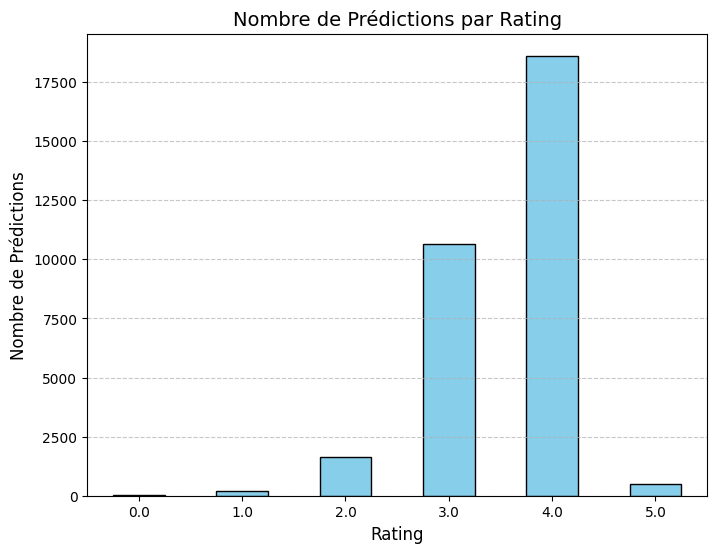

In [96]:
import matplotlib.pyplot as plt

# 4. Comptabiliser le nombre de fois chaque valeur de rating apparaît
rating_counts = df_predictions["prediction(rating)"].value_counts().sort_index()

# 5. Afficher un graphique des comptages des ratings
plt.figure(figsize=(8, 6))
rating_counts.plot(kind="bar", color="skyblue", edgecolor="black")

# Ajouter des titres et des labels
plt.title("Nombre de Prédictions par Rating", fontsize=14)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Nombre de Prédictions", fontsize=12)
plt.xticks(rotation=0)  # Garder les labels sur l'axe X à l'horizontale
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 4. Calculer la moyenne des prédictions
mean_prediction = df_predictions["prediction(rating)"].mean()

# 5. Afficher la moyenne des prédictions
print(f"\nLa moyenne des prédictions est : {mean_prediction}")


# Afficher le graphique
plt.show()


